In [1]:
import os, random, matplotlib, pickle, yaml, hdbscan
import numpy as np
from sklearn.utils import shuffle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

In [2]:
result_path = "../results/round3"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])

In [3]:
config_path = ".."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
skeleton = config['skeleton']
skeleton_color = config['skeleton_color']

In [4]:
root_path = ".."
rot_bp, angles, limbs = [], [], []
angle_power, limb_power = [], []
all_embed = []
labels = []

for file in tqdm(INFO_values):
    # Signal
    rot_bp.append( np.load(f"{root_path}/{file['directory']}/rotated_bodypoints.npy") )
    angles.append( np.load(f"{root_path}/{file['directory']}/angles.npy") )
    limbs.append( np.load(f"{root_path}/{file['directory']}/limbs.npy") )
    # Power
    angle_power.append( np.load(f"{root_path}/{file['directory']}/angle_power.npy") )
    limb_power.append( np.load(f"{root_path}/{file['directory']}/limb_power.npy") )
    # Embeddings
    all_embed.append( np.load(f"{root_path}/{file['directory']}/all_embeddings.npy") )
    # Clusters
    labels.append( np.load(f"{root_path}/{file['directory']}/cluster.npy") )
    
# Signal
rot_bp = np.concatenate(rot_bp)
angles = np.concatenate(angles)
limbs = np.concatenate(limbs)
# Power
angle_power = np.concatenate(angle_power)
limb_power = np.concatenate(limb_power)
# Embeddings
all_embed = np.concatenate(all_embed)
# Clusters
labels = np.concatenate(labels)

In [ ]:
# %matplotlib inline
# %matplotlib qt

<hr>
<hr>

<h1><center> Static Posture Analysis</center></h1>

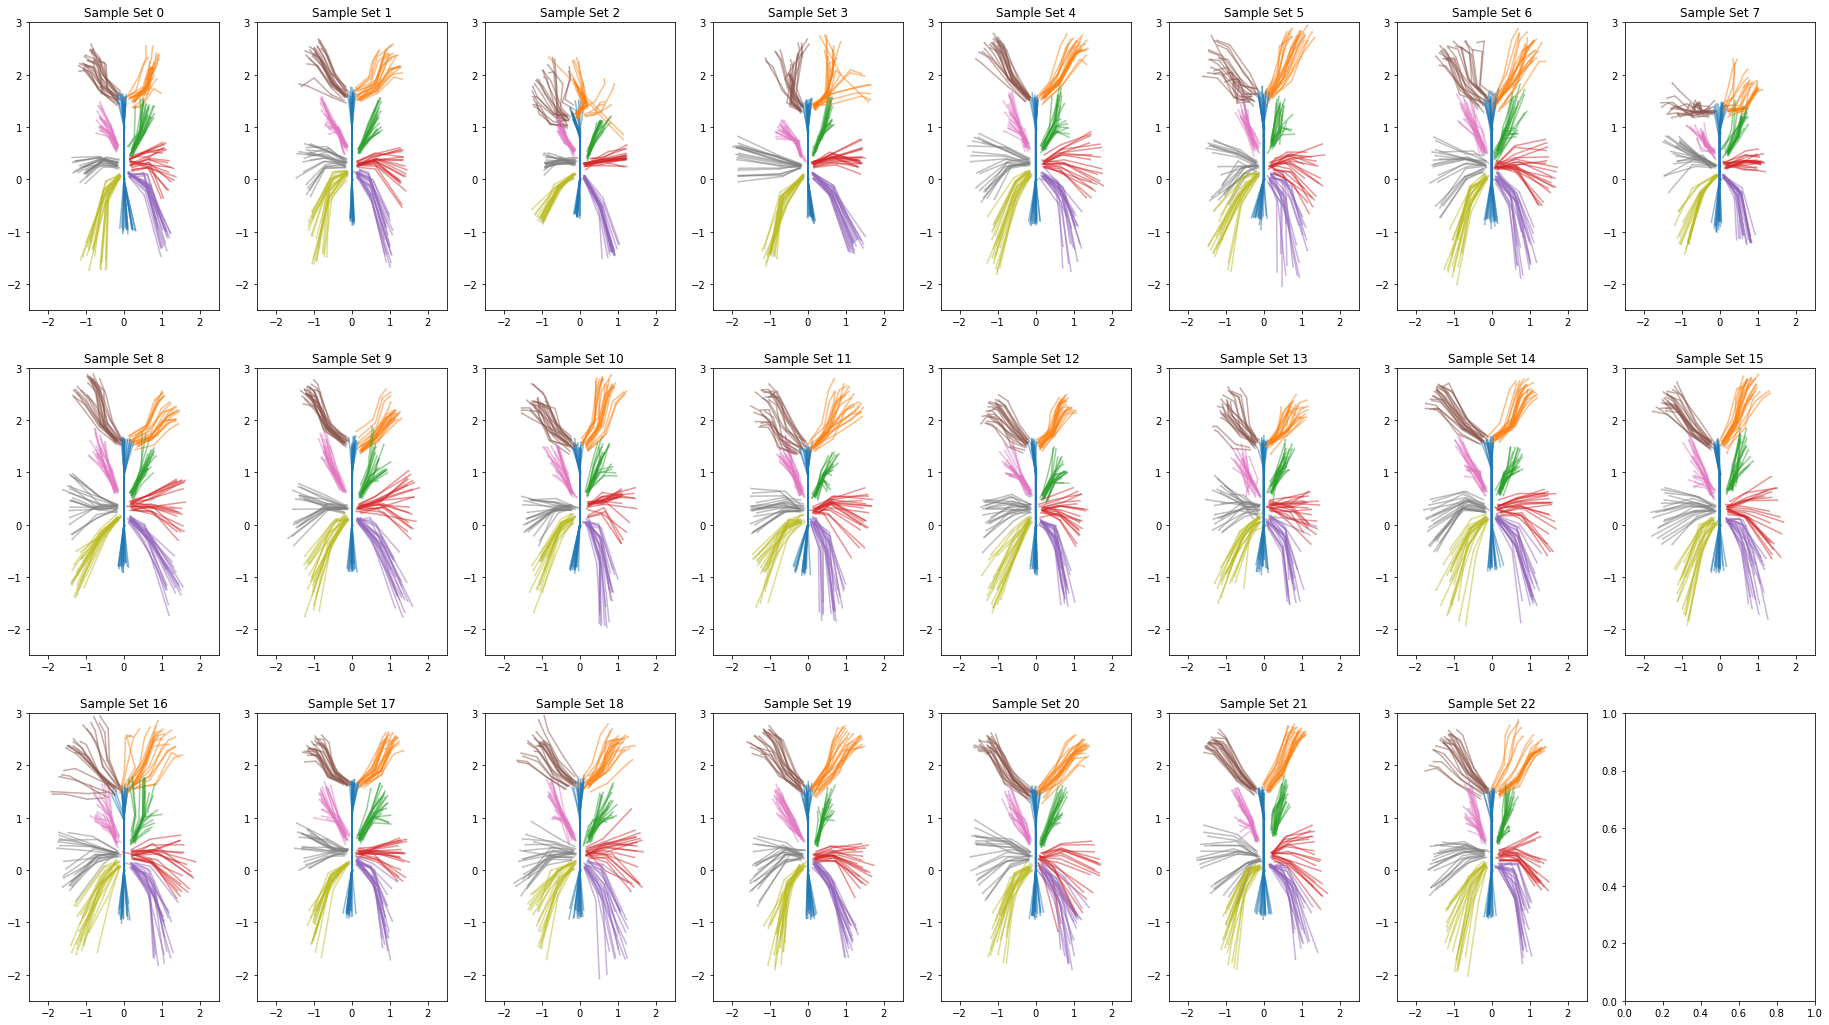

In [13]:
num_clusters = int(np.max(labels)+1)

num_fig_width, num_fig_height = 8,3
fig, ax = plt.subplots(num_fig_height, num_fig_width, figsize=(num_fig_width*4, num_fig_height*6))

for i in np.arange(num_clusters):
    fr_i = np.where(labels == i)[0]
    fr_i = fr_i[:20]
    ax[int(i//num_fig_width), int(i%num_fig_width)].scatter(rot_bp[fr_i,:,0], rot_bp[fr_i,:,1], s=2, alpha=0.05)
    ax[int(i//num_fig_width), int(i%num_fig_width)].set(title= f"Sample Set {int(i)}", xlim=(-2.5,2.5), ylim=(-2.5,3.0))
    
    # build skeleton
    for fr in fr_i:
        for skeleton_i, color_i in zip(skeleton, skeleton_color):
            ax[int(i//num_fig_width), int(i%num_fig_width)].plot(rot_bp[fr,skeleton_i,0], rot_bp[fr,skeleton_i,1], alpha=0.5, c=color_i)
plt.show()

<h1><center> Dynamic Posture Analysis </center></h1>

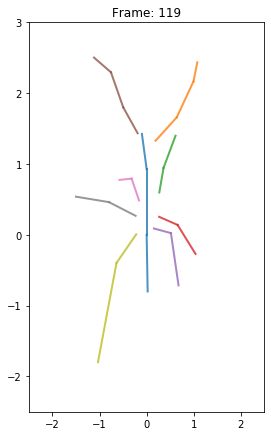

In [42]:
from matplotlib.animation import FuncAnimation

class GIF_Posture:
    def __init__(self, data, xlim, ylim, fig_width, fig_height, cluster=None):
        self.data = data
        self.xlim = xlim
        self.ylim = ylim
        self.fig_width = fig_width
        self.fig_height = fig_height
        self.cluster = cluster
        self.anim = None
        self.lines = []
        
    def _init_posture(self):
        for line in self.lines:
            line.set_data([], [])
        return self.lines
    def _animate_posture(self, i):
        if self.cluster is not None:
            self.ax.set_title(f"Cluster: {int(self.cluster[i])} || Frame: {i}")
        else:
            self.ax.set_title(f"Frame: {i}")
        for line_i, line in enumerate(self.lines):
            line.set_data(self.data[i,skeleton[line_i],0], self.data[i,skeleton[line_i],1])
        return self.lines
    
    def create_gif(self, start_fr, stop_fr, speed=10):
        self.fig, self.ax = plt.subplots(figsize=(self.fig_width, self.fig_height))
        self.fig.tight_layout()
        self.ax.set(xlim=self.xlim, ylim=self.ylim)
        
        for skeleton_i, color_i in zip(skeleton, skeleton_color):
            line, = self.ax.plot([], [], alpha=0.8, c=color_i, linewidth=2)
            self.lines.append(line)
        
        self.anim = FuncAnimation(self.fig, self._animate_posture, init_func=self._init_posture,
                               frames=np.arange(start_fr, stop_fr), interval=1000/speed, blit=True)
    
    def save_gif(self, save_path='figures/test.gif'):
        self.anim.save(save_path, writer='imagemagick')
    
gif_gen = GIF_Posture(rot_bp, xlim=(-2.5,2.5), ylim=(-2.5,3.0), fig_width=4, fig_height=6)

gif_gen.create_gif(start_fr=100, stop_fr=120, speed=10)
gif_gen.save_gif(save_path='figures/test.gif')


/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

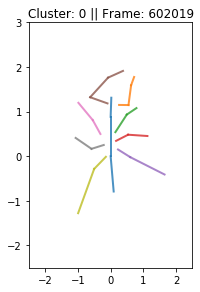

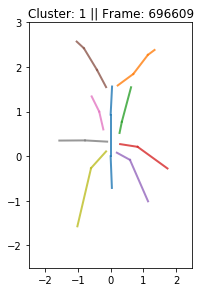

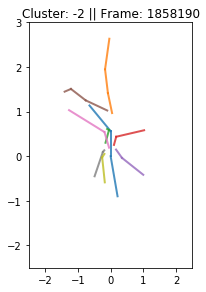

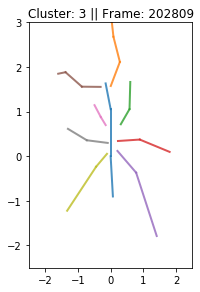

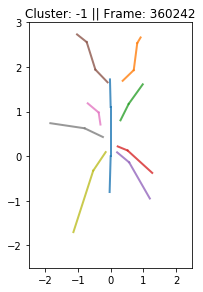

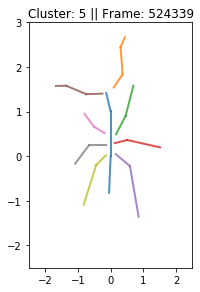

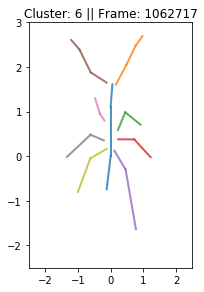

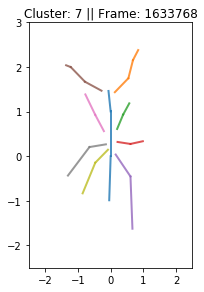

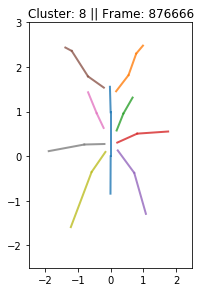

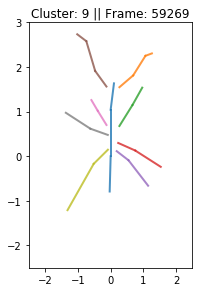

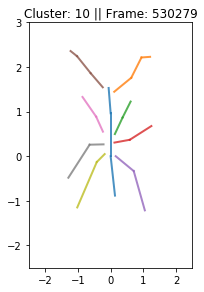

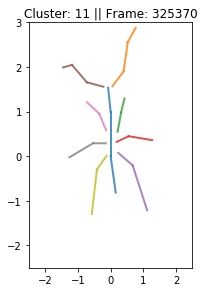

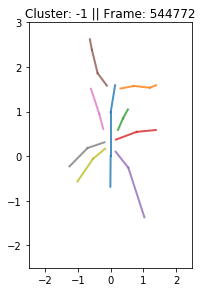

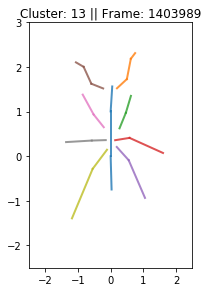

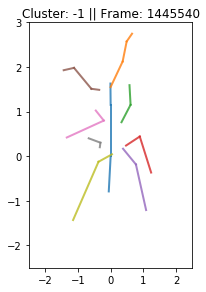

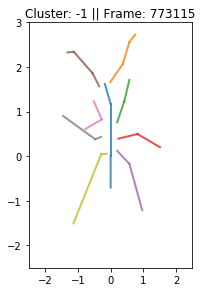

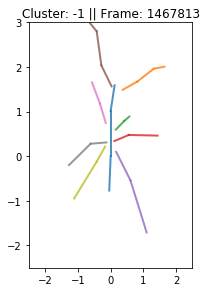

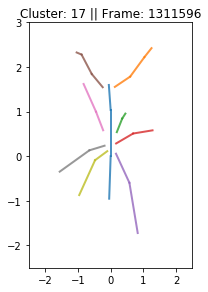

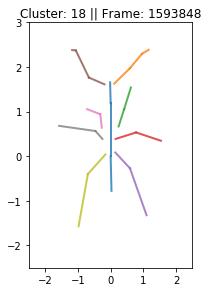

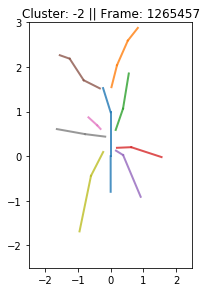

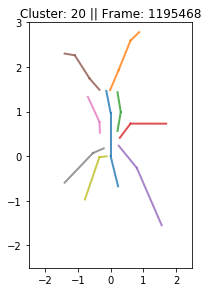

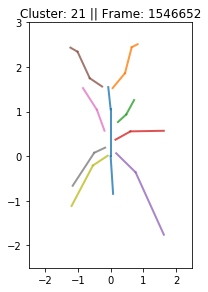

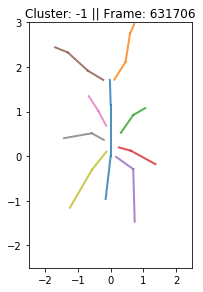

In [46]:
# parameters
fr_length = 15

num_clusters = int(np.max(labels)+1)
for i in np.arange(num_clusters):
    fr_i = np.where(labels == i)[0]
    random_fr = random.sample(list(fr_i), 1)[0]
    
    gif_gen = GIF_Posture(rot_bp, xlim=(-2.5,2.5), ylim=(-2.5,3.0), fig_width=3, fig_height=4, cluster=labels)
    gif_gen.create_gif(start_fr=random_fr, stop_fr=random_fr+fr_length, speed=10)
    gif_gen.save_gif(save_path=f'figures/gif/cluster_{i}.gif')